<a href="https://colab.research.google.com/github/FelixH-git/SVM-Pipeline/blob/main/labb6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()


/tmp/ipython-input-1387014147.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
#housing.head()

In [6]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [7]:
X = train_set[["longitude", "latitude", "median_income"]]

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   longitude      16512 non-null  float64
 1   latitude       16512 non-null  float64
 2   median_income  16512 non-null  float64
dtypes: float64(3)
memory usage: 516.0 KB


In [8]:
Y = train_set["median_house_value"]

In [9]:
from sklearn.cluster import KMeans


# Create the KMeans model
kmeans = KMeans(n_clusters=5, random_state=42)

# Fit the model to the data
kmeans.fit(X)



KMeans(n_clusters=5, random_state=42)

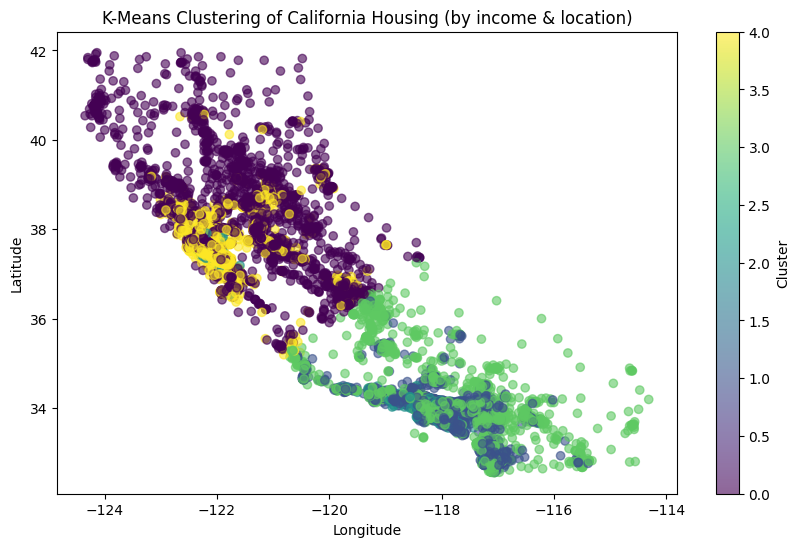

In [10]:
import matplotlib.pyplot as plt


# Add the cluster labels to the dataset
train_set["cluster"] = kmeans.labels_

# Visualize
plt.figure(figsize=(10,6))
plt.scatter(train_set["longitude"], train_set["latitude"],
            c=train_set["cluster"], cmap="viridis", alpha=0.6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering of California Housing (by income & location)")
plt.colorbar(label="Cluster")
plt.show()


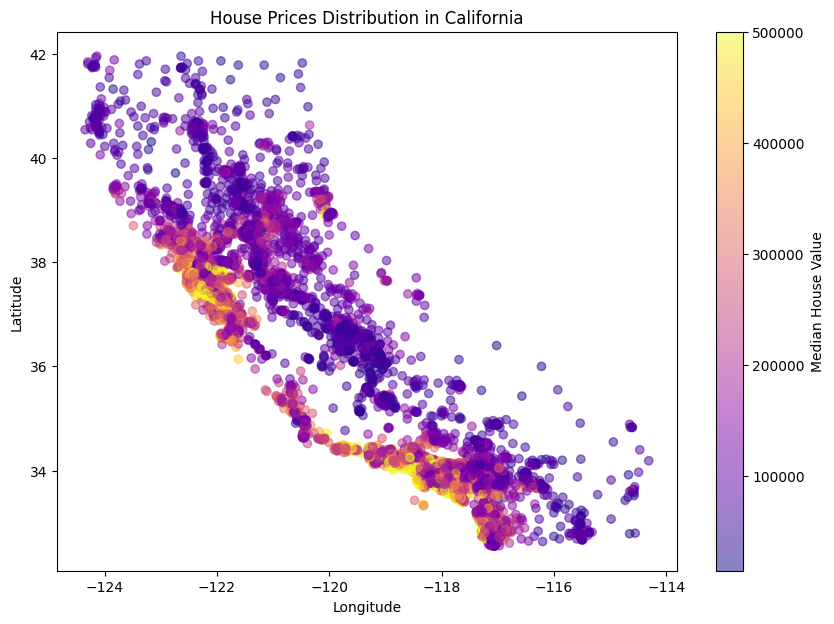

In [11]:
plt.figure(figsize=(10, 7))
plt.scatter(train_set["longitude"], train_set["latitude"],
            c=train_set["median_house_value"], cmap="plasma", alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("House Prices Distribution in California")
plt.colorbar(label="Median House Value")
plt.show()

# Map out which average median house values each cluster belong to

In [12]:
cluster_price_summary = train_set.groupby("cluster")["median_house_value"].mean().sort_values(ascending=False)


print(cluster_price_summary)

cluster
2    463079.114165
4    282187.329309
1    265944.331475
3    165040.829795
0    145186.103262
Name: median_house_value, dtype: float64


In [13]:
kmeans.inertia_

37996.68949072315

In [14]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

np.float64(0.37535704647264845)

In [32]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(2, 20)]
inertias = [model.inertia_ for model in kmeans_per_k]

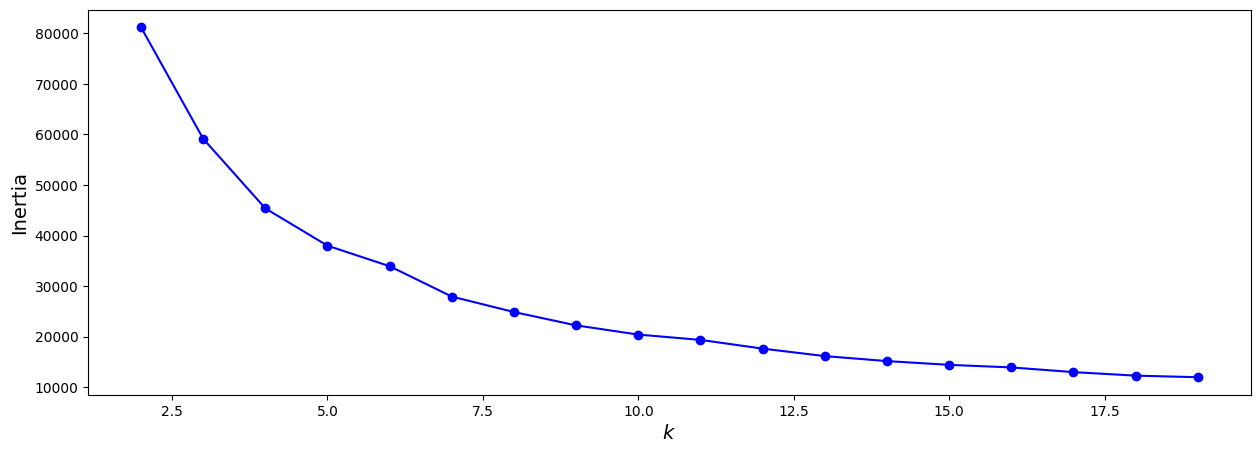

In [37]:
plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

#plt.axis([1, 8.5, 0, 1300])
plt.show()

In [17]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

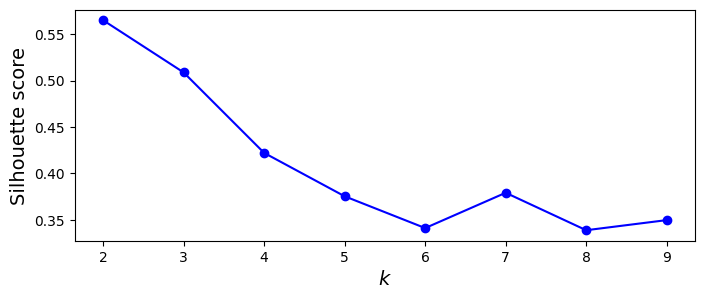

In [18]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

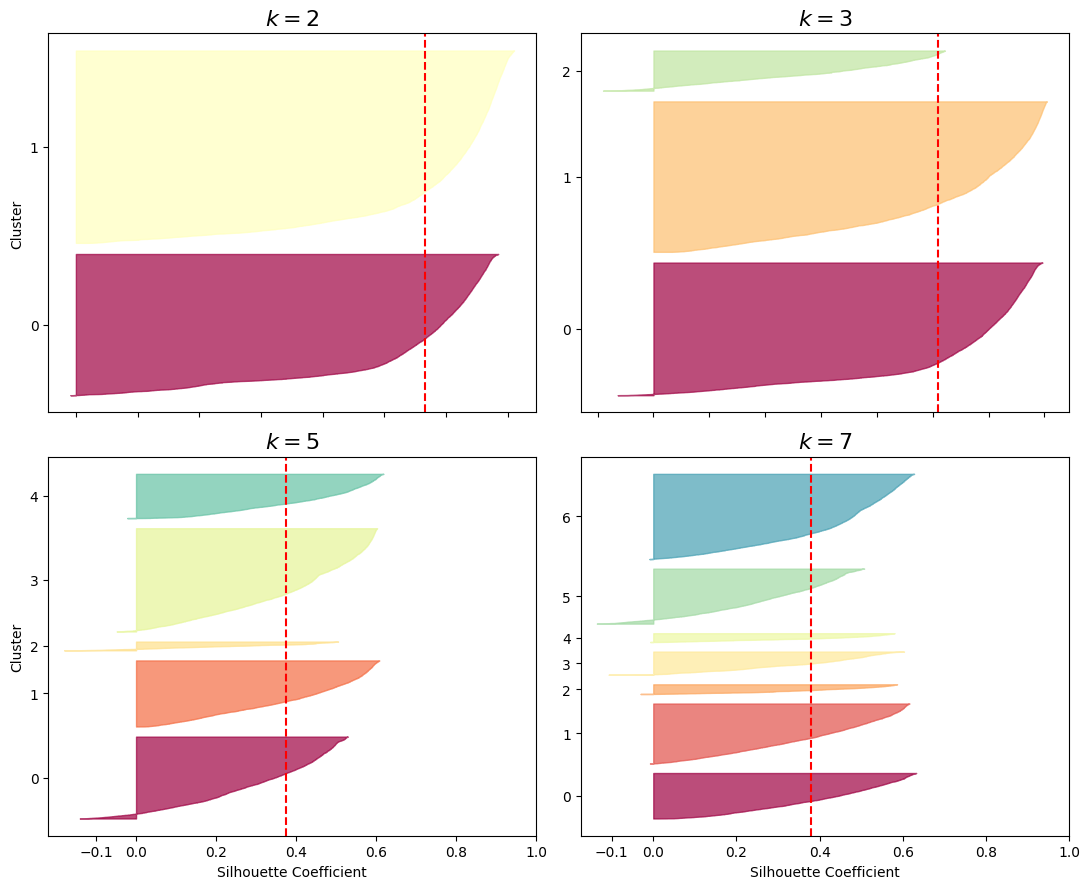

In [19]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
import numpy as np

plt.figure(figsize=(11, 9))

for i, k in enumerate((2, 3, 5, 7), start=1):
    plt.subplot(2, 2, i)  # i goes from 1 to 4
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for j in range(k):
        coeffs = silhouette_coefficients[y_pred == j]
        coeffs.sort()

        color = mpl.cm.Spectral(j / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if i in (1, 3):
        plt.ylabel("Cluster")

    if i in (3, 4):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$", fontsize=16)

plt.tight_layout()
plt.show()


# Lets scale and see

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_set[["longitude","latitude","median_income"]].values)

# then run KMeans on X_scaled
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_scaled)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]



In [30]:
X_scaled.shape

(16512, 3)

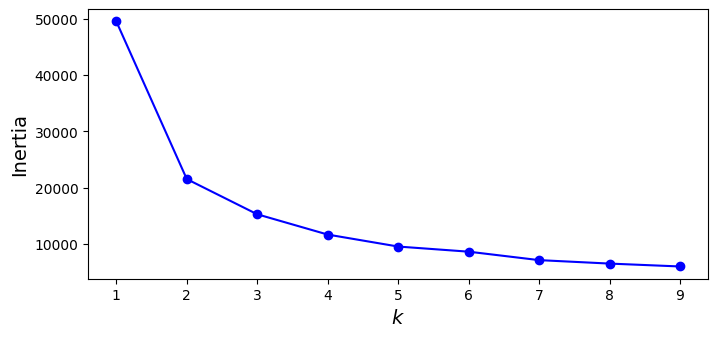

In [25]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

#plt.axis([1, 8.5, 0, 1300])
plt.show()

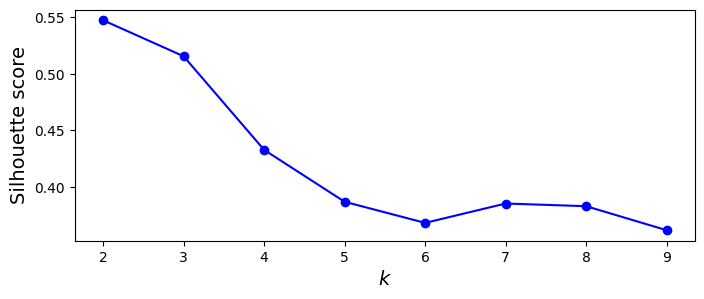

In [26]:
silhouette_scores = [silhouette_score(X_scaled, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

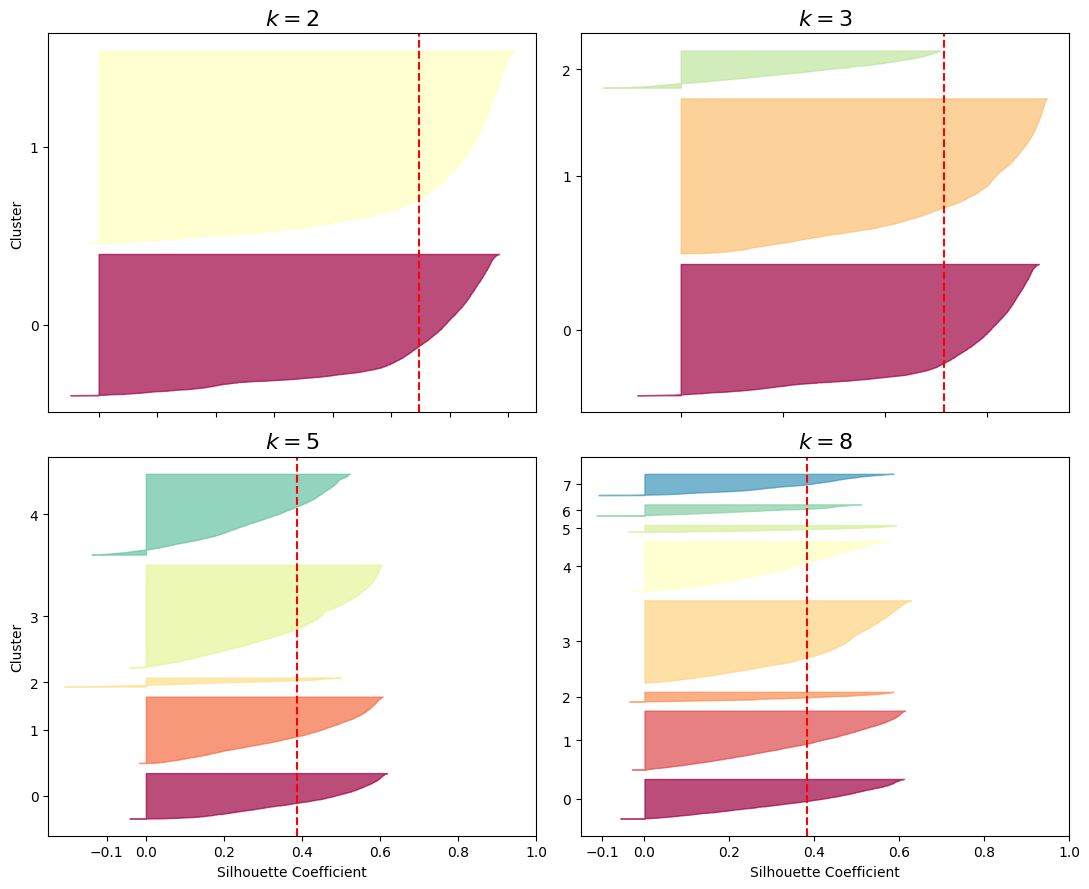

In [31]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
import numpy as np

plt.figure(figsize=(11, 9))

for i, k in enumerate((2, 3, 5, 8), start=1):
    plt.subplot(2, 2, i)  # i goes from 1 to 4
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for j in range(k):
        coeffs = silhouette_coefficients[y_pred == j]
        coeffs.sort()

        color = mpl.cm.Spectral(j / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if i in (1, 3):
        plt.ylabel("Cluster")

    if i in (3, 4):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$", fontsize=16)

plt.tight_layout()
plt.show()


# DBSCAN

In [38]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X_scaled)

DBSCAN(eps=0.05)

In [47]:
dbscan.labels_

array([  0,   1,  -1, ...,   1, 131,   3])

In [40]:
len(dbscan.core_sample_indices_)

9316

In [43]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X_scaled)

DBSCAN(eps=0.2)

In [48]:
dbscan2.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
len(dbscan2.core_sample_indices_)

16021

In [50]:

# DBSCAN clustering
dbscan3 = DBSCAN(eps=0.3, min_samples=10)  # <-- start with eps=0.3 after scaling
dbscan.fit(X_scaled)

# Add labels to dataset
train_set["dbscan_cluster"] = dbscan.labels_

# Inspect the results
unique_labels, counts = np.unique(dbscan.labels_, return_counts=True)
print(dict(zip(unique_labels, counts)))

# Count noise points (label = -1)
n_noise = np.sum(dbscan.labels_ == -1)
print(f"Noise points: {n_noise} ({n_noise / len(train_set):.2%} of data)")

{np.int64(-1): np.int64(5764), np.int64(0): np.int64(659), np.int64(1): np.int64(5033), np.int64(2): np.int64(34), np.int64(3): np.int64(1902), np.int64(4): np.int64(11), np.int64(5): np.int64(134), np.int64(6): np.int64(7), np.int64(7): np.int64(17), np.int64(8): np.int64(447), np.int64(9): np.int64(26), np.int64(10): np.int64(8), np.int64(11): np.int64(85), np.int64(12): np.int64(6), np.int64(13): np.int64(143), np.int64(14): np.int64(8), np.int64(15): np.int64(5), np.int64(16): np.int64(27), np.int64(17): np.int64(23), np.int64(18): np.int64(74), np.int64(19): np.int64(32), np.int64(20): np.int64(8), np.int64(21): np.int64(8), np.int64(22): np.int64(11), np.int64(23): np.int64(9), np.int64(24): np.int64(7), np.int64(25): np.int64(46), np.int64(26): np.int64(38), np.int64(27): np.int64(5), np.int64(28): np.int64(21), np.int64(29): np.int64(17), np.int64(30): np.int64(11), np.int64(31): np.int64(10), np.int64(32): np.int64(8), np.int64(33): np.int64(32), np.int64(34): np.int64(8), np.

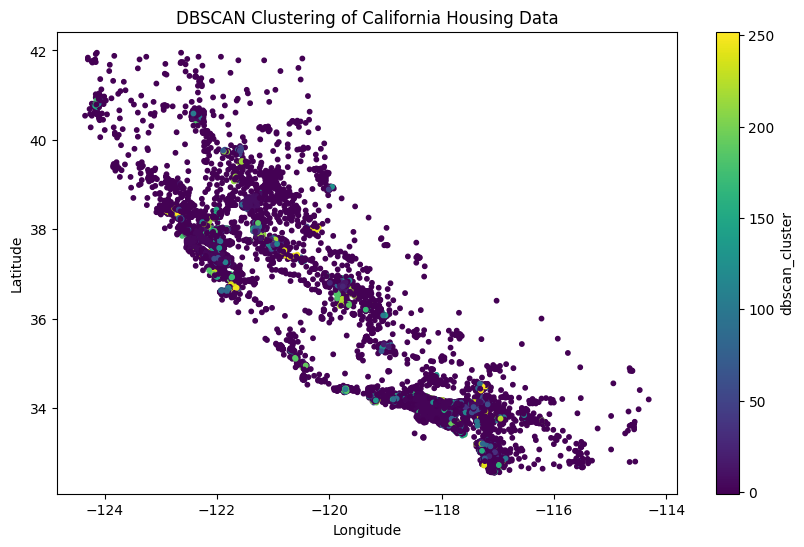

In [52]:
plt.figure(figsize=(10, 6))
plt.scatter(train_set["longitude"], train_set["latitude"],
            c=train_set["dbscan_cluster"], cmap="viridis", s=10)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clustering of California Housing Data")
plt.colorbar(label="dbscan_cluster")

plt.show()

In [54]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
 10  cluster             16512 non-null  int32  
 11  dbscan_cluster      16512 non-null  int64  
dtypes: float64(9), int32(1), int64(1), object(1)
memory usage: 1.6+ MB


In [41]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

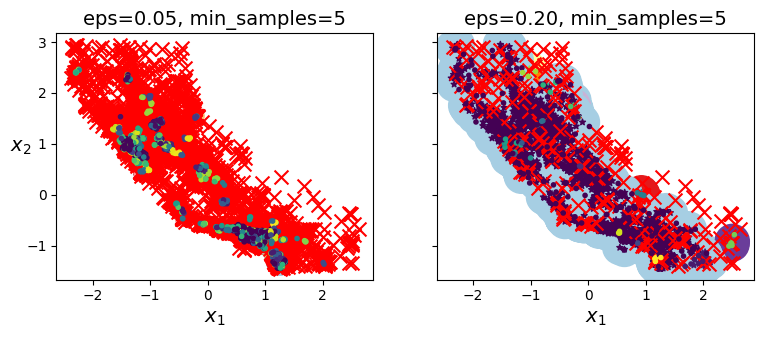

In [45]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X_scaled, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X_scaled, size=600, show_ylabels=False)
plt.show()
